<a href="https://colab.research.google.com/github/muharamulhaq/portfolio/blob/main/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Problem**

The biggest e-commerce company have a potential new webpage designed with the intention to increase their current conversion rates of 12%. We would like to increase this number to 14%. Therefore, we created A/B-test to ensure that a new version of a site will certainly increase the conversion. What do we do?

**Data :**

* **user_id** contains user id
* **timestamp** is about when a session was
* **group** contains 2 variables: control and treatment
* **landing_page** is about what version of a site a user saw
* **converted** says us about user's behavior: if a user made a purchase (1) or not (0)

In [52]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math as mt
import itertools
import statsmodels.stats.api as sms
from math import ceil
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
#import data 

df = pd.read_csv("/content/drive/MyDrive/Digital Skola/Dataset/ab_data.csv")
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**Data Cleansing**

In [3]:
df.shape

(294478, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [11]:
df[df["user_id"].duplicated()].head()

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0


In [9]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

* In user id there is duplicate data
* Nothing missing value

In [28]:
df.drop_duplicates(subset="user_id", keep="first", inplace=True)

In [29]:
df.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [30]:
df.shape

(290584, 5)

In [31]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1006,144226
treatment,144314,1038


In [36]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.9,  #power of a test (defualt is 0.8)
    alpha=0.05, #p-value
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

5934


we need 5134 users in control and 5134 users in treatment group.

In [37]:
control_group = df.query('group == "control"').sample(required_n)
treatment_group = df.query('group == "treatment"').sample(required_n)

In [38]:
control_group.head()

,user_id,timestamp,group,landing_page,converted
227544,682454,2017-01-03 18:55:35.399893,control,old_page,0
13082,829950,2017-01-13 09:11:11.588430,control,old_page,0
267607,888483,2017-01-08 09:54:16.778912,control,old_page,0
190696,669746,2017-01-15 20:07:33.543528,control,old_page,0
280450,922803,2017-01-12 14:41:44.377442,control,old_page,0


In [39]:
treatment_group.head()

,user_id,timestamp,group,landing_page,converted
48885,844731,2017-01-12 07:38:18.884685,treatment,new_page,0
141597,916333,2017-01-11 18:28:05.767211,treatment,new_page,0
112881,766038,2017-01-22 18:28:31.374282,treatment,new_page,0
21922,928969,2017-01-15 19:34:45.923544,treatment,new_page,0
140030,933749,2017-01-10 22:39:30.296917,treatment,new_page,1


In [40]:
ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(inplace=True, drop=True)

In [41]:
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,682454,2017-01-03 18:55:35.399893,control,old_page,0
1,829950,2017-01-13 09:11:11.588430,control,old_page,0
2,888483,2017-01-08 09:54:16.778912,control,old_page,0
3,669746,2017-01-15 20:07:33.543528,control,old_page,0
4,922803,2017-01-12 14:41:44.377442,control,old_page,0


In [42]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11868 entries, 0 to 11867
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       11868 non-null  int64 
 1   timestamp     11868 non-null  object
 2   group         11868 non-null  object
 3   landing_page  11868 non-null  object
 4   converted     11868 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 463.7+ KB


In [43]:
ab_test.group.value_counts()

control      5934
treatment    5934
Name: group, dtype: int64

In [46]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.118,0.323,0.004
treatment,0.120,0.325,0.004


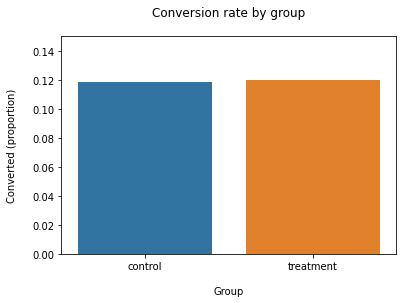

In [51]:
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

The control group shows us 11.8% conversion rate and the treatment group 12% conversion rate.

In [53]:
control_conversion = ab_test.query('group == "control"')['converted']
treatment_conversion = ab_test.query('group == "treatment"')['converted']

In [54]:
nobs = [control_conversion.count(), treatment_conversion.count()]
successes = [control_conversion.sum(), treatment_conversion.sum()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.28
p-value: 0.777
95% Confidence interval for control group: [0.110, 0.127]
95% Confidence interval for treatment group: [0.112, 0.128]


Despite the fact, that from the first sight the conversation rate of the treatment group seemed to be slightly higher, p-value>0.05 --> we cannot accept the alternative hypothesis. Besides, the confident intervals include our baseline value of 12% conversion rate.

Therefore, this new version of the site cannot increase conversion significantly. With the results of the A/B-test we came to conclusion, that it makes no sense for the company to introduce a new version of the site.